## 深度解析bellman（导言）

bellman是一个用rust语言实现的zksnark(groth16算法)库，接口调用非常方便，算法实现抽象程度非常高，不同功能模块例如有限域、群、BLS12_381椭圆曲线等实现都放在不同的crate里，因此也比较适合针对不同的模块单独进行优化，例如filecoin项目就是fork了bellman，实现了一个bellperson项目（两个项目有一个相同的主要作者Sean Bowe），在bellperson项目里，就把纯rust实现的bls12-381换成了汇编实现的blstrs，单纯在cpu上运行就有60%以上的性能提升，然后再加上对iFFT在GPU上用cuda实现，性能提升可以达到几个数量级。

### 使用bellman
本文写作的时候，bellman最新版本为0.13.1，在cargo.toml里申明依赖即可：
```
bellman = "0.13.1"
```

#### Step1：定义一个电路
假设证明我知道方程 $ a * 3 = 21 $ 有一个解$a=7$，先定义一个结构：
```
pub struct MultiplyDemo <S: PrimeField>{
    pub a: Option<S>,
    pub c: Option<S>
}
```

然后实现circuit这个trait，其中最重要的是要实现syntehsize电路合成这个方法：
```
impl<'a, S: PrimeField> Circuit<S> for MultiplyDemo <S> {
    fn synthesize<CS: ConstraintSystem<S>>(
        self, 
        cs: &mut CS
    ) -> Result<(), SynthesisError>
    {
        
        // Allocate the first value (private)
        let a = cs.alloc(|| "a", || {
            self.a.ok_or(SynthesisError::AssignmentMissing)
        })?;
        
        // Allocate the second value (private)
        let b = cs.alloc(|| "b", || {
            let mut tmp = S::from_str_vartime("3").unwrap();
            Ok(tmp)
        })?;
        
        // Allocate the third value (private)
        // allocating a public input uses alloc_input
        let c = cs.alloc(|| "c", || {
            self.c.ok_or(SynthesisError::AssignmentMissing)
        })?;

        // a * b = c?
        cs.enforce(
            || "a * b = c",
            |lc| lc + a,
            |lc| lc + b,
            |lc| lc + c
        );
        
        Ok(())
    }
}

```
因为这个问题如此简单，只需要用内置的ConstraintSystem::enforce方法就可以搭建一个电路，其中alloc_input方法保存电路的公开输入，alloc保存电路的私有输入，在创建证明参数时，公开输入为None，同一个电路可以验证不同的输入。把一个任意的计算类问题，转化成电路，在很多时候需要一定的想像力，在Groth16算法里，提供了一个R1CS指出理论上任意的计算类问题，都可以用R1CS来表达，从而可以用zksnark来证明。直接用r1cs合成电路，几乎和写汇编的难度以及工作量差不多，所以在bellman库里实现了几个gadget，例如sha256，blake2s等，在circom等工具里也提供了现成的电路模块，用于搭建复杂的电路像merkle等。


#### Step2：创建参数
```
    // Create parameters for our circuit
    let params = {
        let c = MultiplyDemo {
            a: None,
            c: None
        };

        generate_random_parameters::<Bls12, _, _>(c, &mut rng).unwrap()
    };
```
这一步对所有的bellman应用来说都是一样的，generate_random_parameters这个方法就是所谓的根据随机数和电路，创建CRS、ProvingKey、VerifyingKey，不同复杂程度的电路，最终生成的parameters大小不同，例如在filecoin中，由于电路超级复杂，最终生成的parameters大小有几百G之多。

#### Step3：创建证明
```
    // Create an instance of circuit
    let c = MultiplyDemo {
        a: Fr::from_str_vartime("7"),
        c: public_input
    };
    
    // Create a groth16 proof with our parameters.
    let proof = create_random_proof(c, &params, rng).unwrap();
```
这一步对所有的bellman应用来说也都是一样的，可以打印Proof的内容，其实就是3个椭圆曲线上的点(a,b,c)，其中a和c是G1的，其x，y坐标都位于$\mathbb F_q $中，分别用32个字节（256位）表示，b属于G2，其x，y坐标分别是一元一次多项式表示，每个多项式需要2个$\mathbb F_q $元素表示多项式的系数，这样算下来总共需要256个字节，不过在很多比较zksnark和zkstark、plonky等数据的文章中，都指出zksnark的proof其size为288个字节，这个是基于pinocho协议或者Groth13的版本，而这个版本确实更为流行，很多学习材料或者解释文章都基本引用的是这个算法。下图引用来自于groth16论文https://eprint.iacr.org/2016/260.pdf 原图，因此其中“this work”代指groth16算法本尊，所以当比照理解算法和bellman代码的时候，就不要惊讶怎么和网上众多的文章不完全一样呢。<br>
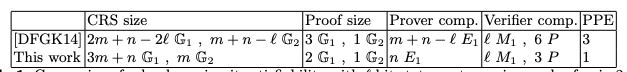

proof = (a=G1Affine { x: 0x098cbd80d1f7c559f3b3275e2c358ee2baafff23798c7813629cdf15887327e1cbb6382c0db0a83e5c974a2a15114dc7, y: 0x19831f695617e66b88a882f94bac299fad21f96be835c0f9740c1a8cd418570334426f8109df7d61821c478469bcf3b4, infinity: Choice(0) }, b=G2Affine { x: 0x0b3d2d75387b90a3091a838a19527becfde848d51ab0375d10aaf2d78b11c355b2a1e64dc7db469927eba4b491c85d30 + 0x057464574980f767aede84112c86a124c867cda7cd1a2a212dce4df84c81ac6a56bdc933c5ea5090340d127ae8540bc4*u, y: 0x14557791d821178b3458f6526235f57489347a20bf5ea9c775aed0bef3ab51ca83221c5630822f8767dd8eba365b89d2 + 0x05352ed7d8744b39e2d36ce813a2010e00f15c1e90617011bcb8fbfd2ba552068b4e6d95f01ca15443e13f32bbcfb678*u, infinity: Choice(0) }, c=G1Affine { x: 0x10028825c58874c6893057725de813aab1b06daf6c358ebade53fc9104f73c1511d6a0a6df341dcd436d7176fc16978f, y: 0x0173d5b82f079ee31aaa14ff34f30b4e015c878e3d2fee71aa649a5e473ccae3e0eef320346d7767d56dc12a15d5dd78, infinity: Choice(0) } )

#### Step4：验证证明
```
    println!("{}", verify_proof(
        &pvk,
        &proof,
        &[public_input.unwrap()]
    ).is_ok());
```
这一步对所有的bellman应用来说也都是一样的。这里解释几个知识点：<br>
1、CRS(common reference string)：公共信息，包括了pk、vk、随机数（加密后）等信息，也可以认为电路信息也包含在CRS里。<br>
2、零知识，在step4验证证明的时候，其输入为vk、proof、public input，其中public input对应于合成电路方法中的alloc_input，除此之外，verifier并不知道prover生成proof的秘密输入a。<br>
3、简洁性，生成的proof大小只有288个字节，实际包括3个椭圆曲线上的点，verifier在验证的时候，并不需要执行电路，耗费的计算资源跟prover相比差几个数量级。<br>

### 总结
bellman库的使用比较简单直接，关键在于如何定义电路，看来要想真正用好bellman，需要深入了解更多的gadget，或者结合circom等电路定义工具来使用。